## Flow matching in spherical Reimannian submanifold

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_swiss_roll

In [2]:
if torch.cuda.is_available() :
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
def S2exp_map(p,v,r=1):

    dist = torch.linalg.norm(v, dim=1, keepdims=True)
    non_zero_mask = (dist != 0)
    v_normalized = torch.zeros_like(v).to(device)
    if torch.any(non_zero_mask):
      v_normalized[non_zero_mask.flatten(), :] = v[non_zero_mask.flatten(), :] / dist[non_zero_mask,None]

    q = torch.where(dist == 0,p,  torch.cos(dist/r)*p + torch.sin(dist/r)*(v_normalized))
    return q

def S2log_map(p,q,r=1):

    dot = torch.sum(p * q, dim=1, keepdims=True)/r**2
    theta = torch.arccos(torch.clip(dot, -1, 1))

    dist = theta*r
    v = torch.where(theta == 0,torch.zeros_like(q).to(device),dist/torch.sin(theta+1e-8) * (q - dot*p))

    return v

def S2_pt(p,q,v,r=1):
    theta = torch.arccos(torch.clamp(torch.sum(p * q, dim=1, keepdims=True)/r**2, -1, 1))
    axs = torch.cross(p,q,dim=1)
    norm_axs = torch.linalg.norm(axs, dim=1, keepdims=True)
    axs = axs/ (norm_axs +1e-8)

    v_q = torch.cos(theta)*v + torch.sin(theta)*torch.cross(axs,v, dim=1) + (1-torch.cos(theta))*(axs*v).sum(axis=1,keepdims=True)*axs
    return v_q

def S2_geodesic_dist(p,q,r=1):
    theta = torch.arccos(torch.clamp(torch.sum(p * q, dim=1, keepdims=True)/r**2, -1, 1))
    return theta*r

In [4]:
def make_checkboard(num_samples):
    x2 = np.random.rand(num_samples,2)

    x2[(x2[:,0] // 0.25 + x2[:,1] // 0.25) %2 == 0,0] +=  0.25
    x2[x2 > 1.0] -= 1
    x2 -= [0.5,0.5]
    x2 *= 2
    return x2

In [5]:
def get_sphere():
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
    return x_sphere, y_sphere, z_sphere



def plot_3d(x,title="",color='blue'):
  with torch.no_grad():
      fig = plt.figure(figsize=(10, 8))
      ax = fig.add_subplot(111, projection='3d')

      x_sphere, y_sphere, z_sphere = get_sphere()

      ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.3, color='lightblue')
      x = x.cpu().detach().numpy()
      ax.scatter(x[:, 0], x[:, 1], x[:, 2], color=color, s=20)
      ax.set_box_aspect([1,1,1])
      ax.view_init(elev=0,azim=25)

      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_zlabel('Z')
      ax.set_title(f'{title}')
      plt.show()


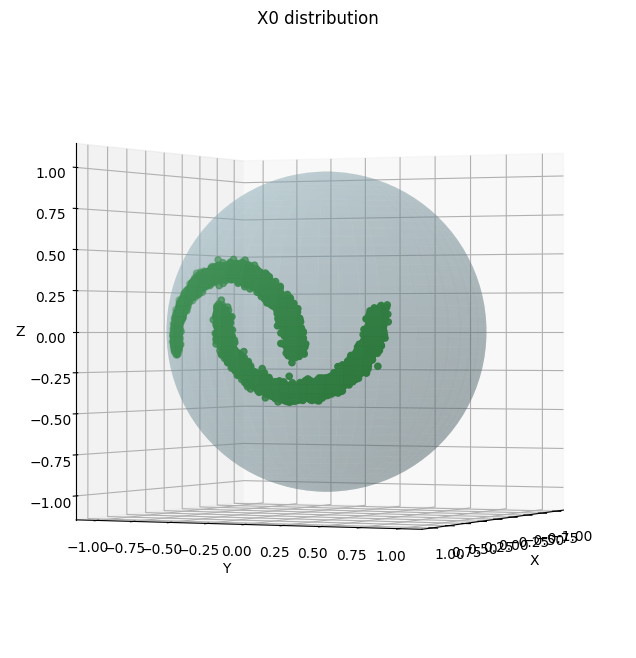

In [18]:

num_train_data = 10000

P0 = torch.tensor([[1.0,0,0]],device=device)

sample_X0 = lambda x: make_moons(x,noise=0.05)[0]*0.5
# X0_std = 0.2
# X0_dist = torch.randn(num_train_data,3,device=device)*0.2
# X0_dist[:,0] = 0

X0_dist = torch.zeros((num_train_data,3),device=device)
X0_dist[:,1:] = torch.from_numpy(sample_X0(num_train_data))
X0_dist -= torch.mean(X0_dist,dim=0,keepdim=True)


X0_dist = S2_pt(torch.tensor([[1.0,0,0]],device=device),P0,X0_dist)
X0_exp = S2exp_map(P0,X0_dist).to(torch.float32)
plot_3d(X0_exp,"X0 distribution","green")




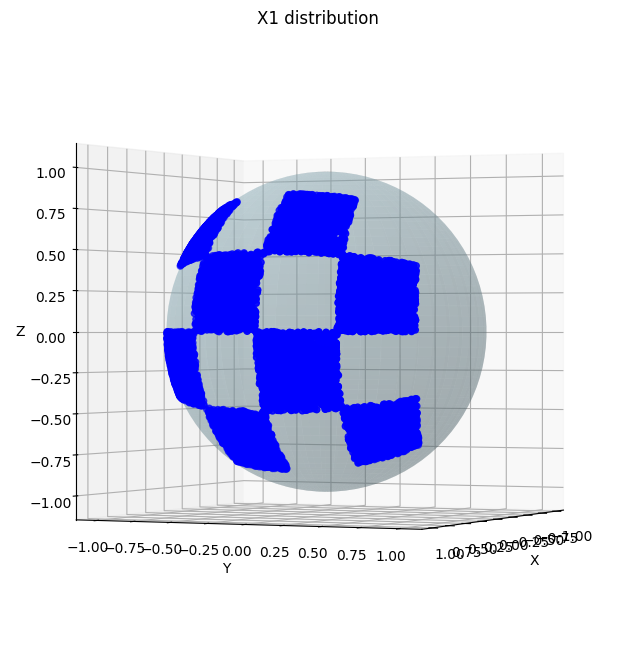

In [19]:
X1_data = make_checkboard(num_train_data)
np.random.shuffle(X1_data)

X1_data = torch.from_numpy(X1_data)
X1_data = S2exp_map(torch.tensor([[1, 0, 0]]).to(device), torch.column_stack([torch.zeros_like(X1_data[:,0]),X1_data]).to(device)).to(dtype=torch.float32)

plot_3d(X1_data,"X1 distribution")

In [7]:
def sample_xt(x0,x1,t):
    tangent_xt = t * S2log_map(x0,x1)
    return S2exp_map(x0, tangent_xt)

def grad_S2geodesic(x,y,r=1):
    cos_theta = torch.sum(x * y, dim=1, keepdim=True)
    sin_theta = torch.sqrt(torch.clamp(1 - cos_theta**2, min=0.0))

    if r == 1:
        return - (y - cos_theta * x) / (sin_theta + 1e-8)
    else:
        tangent_x1 = -S2log_map(x, y)
        return tangent_x1 / (torch.linalg.norm(tangent_x1, dim=1, keepdim=True) + 1e-8)

In [8]:
def get_t_encodings(t,num_freqs):

    enc = torch.full((t.shape[0],num_freqs*2+1),2,dtype=torch.float32).to(device)
    p = torch.arange(num_freqs)[None,:].to(device)
    enc[:,1:num_freqs+1] = (enc[0,:num_freqs]**p)[:,None,:]*t*np.pi
    enc[:,num_freqs+1:] = enc[:,1:num_freqs+1]
    enc[:,1:num_freqs+1] = torch.sin(enc[:,1:num_freqs+1])
    enc[:,num_freqs+1:] = torch.cos(enc[:,num_freqs+1:])
    enc[:,0] = t[:,0]
    return enc

num_hid_layers = 3
num_freq = 5
model = nn.Sequential(
        nn.Linear(3+num_freq*2+1,256),
        nn.ReLU(),
        *[m for _ in range(num_hid_layers) for m in (nn.Linear(256, 256), nn.ReLU())],
        nn.Linear(256,3)
)

model = model.to(device)

In [9]:
print_every = 20
learning_rate = 2e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
num_epoch = 2000
mb_size = 512
loss_func = torch.nn.MSELoss()

for e in range(num_epoch):
    if e%print_every == 0:
        acc_loss = 0
    for b in range(len(X0_exp)//mb_size + 1):
        x0_ind = torch.randint(0,len(X0_exp),(mb_size,))
        x1_ind = torch.randint(0,len(X1_data),(mb_size,))

        x0 = X0_exp[x0_ind]
        x1 = X1_data[x1_ind]

        t = torch.rand(x0.shape[0],1,device=device)
        xt = sample_xt(x0,x1,t)

        delta_d = grad_S2geodesic(xt,x1)
        valid_grad_mask = torch.linalg.norm(delta_d,dim=1)<1.5

        target_vector = - S2_geodesic_dist(x0,x1)*delta_d/torch.linalg.norm(delta_d,dim=1,keepdims=True)

        enc_rand_time = get_t_encodings(t,num_freq)

        vector_pred = model(torch.concat((xt,enc_rand_time),axis=1))
        tan_vector_pred = (vector_pred - torch.sum(vector_pred*xt,dim=1,keepdims=True)*xt)

        optimizer.zero_grad()
        loss = loss_func(target_vector[valid_grad_mask],tan_vector_pred[valid_grad_mask])
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
    if e%print_every == 0:
        print(f"epoch:{e} loss: {acc_loss/(b*print_every)}")


epoch:0 loss: 0.012093111715818707
epoch:20 loss: 0.009744318260958321
epoch:40 loss: 0.009261441779764075
epoch:60 loss: 0.00903389371539417
epoch:80 loss: 0.009200215692582883
epoch:100 loss: 0.009086726252969943
epoch:120 loss: 0.008916828663725602
epoch:140 loss: 0.008709852240587535
epoch:160 loss: 0.008868373263823358
epoch:180 loss: 0.008942138560508427
epoch:200 loss: 0.008912379255420284
epoch:220 loss: 0.008952166061652334
epoch:240 loss: 0.00868388120281069
epoch:260 loss: 0.00883869532691805
epoch:280 loss: 0.008705470397284157
epoch:300 loss: 0.008819915079756787
epoch:320 loss: 0.008851475856806103
epoch:340 loss: 0.0087240453221296
epoch:360 loss: 0.008667527452895516
epoch:380 loss: 0.008700225580679743
epoch:400 loss: 0.008859260458695261
epoch:420 loss: 0.008497421129753715
epoch:440 loss: 0.008448649472311923
epoch:460 loss: 0.008711637791834379
epoch:480 loss: 0.008775926263708817
epoch:500 loss: 0.008770189708785008
epoch:520 loss: 0.008677338573493456
epoch:540 lo

In [10]:
with torch.no_grad():
    num_time_steps = 100
    num_test_samples = 2000
    start_t = 0.0
    end_t = 1.0-start_t

    step_size = (end_t-start_t)/num_time_steps

    # X0_dist = torch.randn(num_test_samples,3)*X0_std
    # X0_dist[:,0] = 0
    X0_dist_test = torch.zeros((num_train_data,3),device=device)
    X0_dist_test[:,1:] = torch.from_numpy(sample_X0(num_train_data))
    X0_dist_test -= torch.mean(X0_dist_test,dim=0,keepdim=True)
    X0_dist_test = S2_pt(torch.tensor([[1.0,0,0]],device=device),P0,X0_dist.to(device))
    xt_sample = S2exp_map(P0,X0_dist_test).to(torch.float32)

    xts = []
    t = torch.full((len(xt_sample),1),start_t).to(device)
    for n in range(num_time_steps):
        vec_pred = model(torch.concat((xt_sample,get_t_encodings(t,num_freq)),axis=1))
        tan_vec_pred = (vec_pred - torch.sum(vec_pred*xt_sample,dim=1,keepdims=True)*xt_sample)
        xt_sample = S2exp_map(xt_sample,step_size*tan_vec_pred)
        t += step_size
        xts.append(xt_sample.detach().cpu().clone())


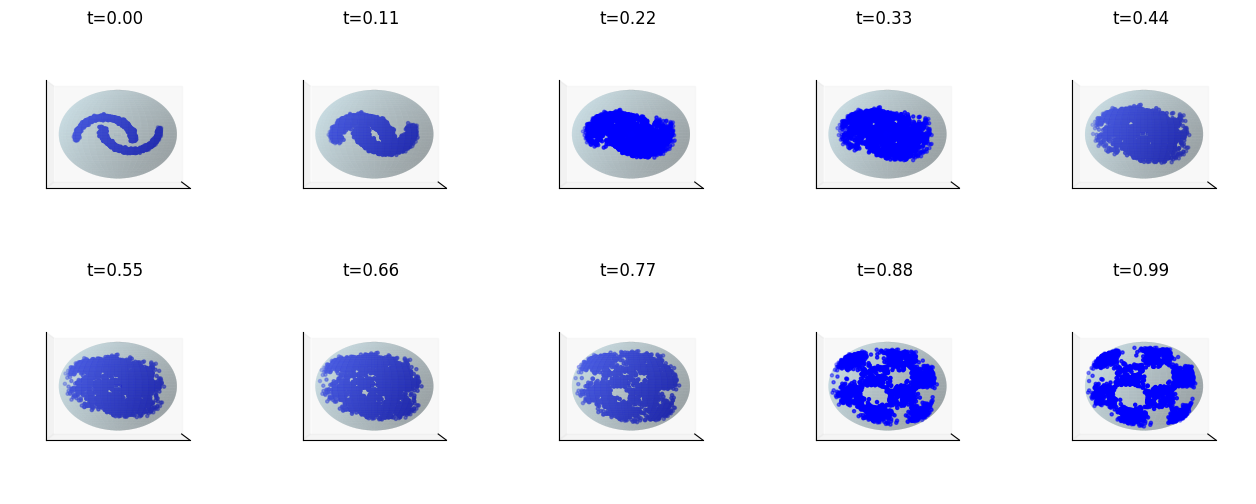

In [11]:
fig, axs = plt.subplots(2,5,figsize=(16,6))
x_sphere, y_sphere, z_sphere = get_sphere()
i=j=0
for k in np.linspace(0,len(xts)-1,10):
    if j!=0 and j%5==0:
        i+=1
        j=0
    k = int(k)

    axs[i,j].remove() # Remove the default 2D subplot
    axs[i,j] = fig.add_subplot(axs[i,j].get_subplotspec(), projection='3d') # Add a 3D subplot in its place

    num_points = 2000
    axs[i,j].plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.3, color='lightblue')
    axs[i,j].scatter(xts[k][:num_points, 0], xts[k][:num_points, 1], xts[k][:num_points, 2], color='blue', s=5)
    axs[i,j].set_title(f"t={abs(start_t-k/len(xts)):.2f}")
    axs[i,j].view_init(elev=0,azim=0)


    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].set_zticks([])
    j+=1

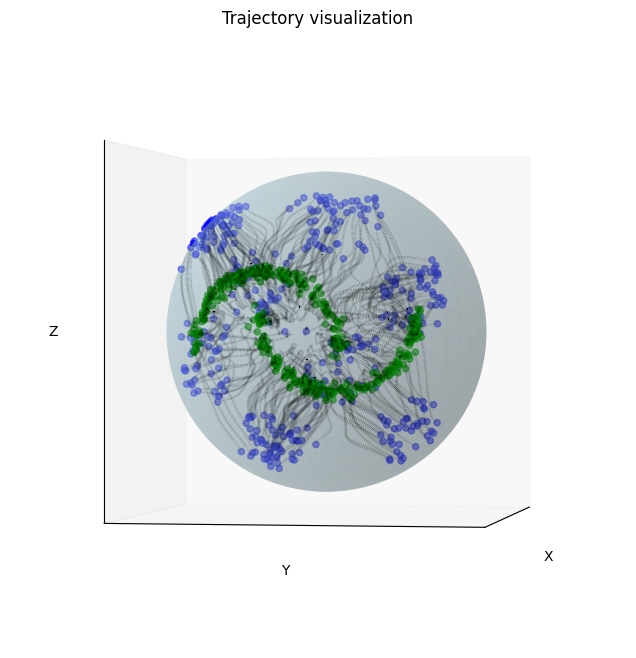

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x_sphere, y_sphere, z_sphere = get_sphere()

num_points = 400
ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.3, color='lightblue')
ax.scatter(xts[0][:num_points, 0], xts[0][:num_points, 1], xts[0][:num_points, 2], color='green', s=20,alpha=0.5)

for i in range(len(xts) - 1):
    current_points = xts[i][:num_points, :]
    next_points = xts[i+1][:num_points, :]
    ax.quiver(current_points[:, 0], current_points[:, 1], current_points[:, 2],
              (next_points - current_points)[:, 0], (next_points - current_points)[:, 1], (next_points - current_points)[:, 2],
              color='black', length=0.05, arrow_length_ratio=0.5)


ax.scatter(xts[-1][:num_points, 0], xts[-1][:num_points, 1], xts[-1][:num_points, 2], color='blue', s=20,alpha=0.5)


ax.set_box_aspect([1,1,1])
ax.view_init(elev=0,azim=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_title('Trajectory visualization')
plt.show()